# MCMC for Neural Net regression


In this notebook, we'll cover

* Part 0: NN regression model recap
* Part 1: Posterior prediction
* Part 2: Sampling with Markov Chains
* Part 3: Designing Markov chains to have specific stationary distributions
* Part 4: Implementing a Random Walk Sampler
* Part 5: Towards Hamiltonian Monte Carlo

# Prerequisites

You should have already completed the [day03-C: Neural Nets in JAX](https://github.com/tufts-ml-courses/cs152BDL-22f-assignments/blob/main/day03-B-NeuralNetsJax.ipynb) notebook, where you'd see the neural net coding approach we'll use here.

We'll lean a bit on today's assigned reading: Betancourt (2017), though the narrative story here will be more direct and focused on our NN regression model. 


# Requirements

There are two ways to run this notebook

<table style="table-medium">
    <tr>
        <td style="align:left; text-align:left;"> <h2> Run in-browser (no install necessary) </h2>
        </td>
        <td style="align:left; text-align:left;"> <h2> Run locally on your computer </h2>
        </td>        
    </tr>
    <tr>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://colab.research.google.com/">Google Colab </a> </p>
             <p>You'll need:</p>
             <ul>
             <li> internet connection </li>
             <li>  Modern browser (Firefox, Chrome, Safari, Edge, etc) </li>
             <li> Google account </li>
             <li> Warning: session will timeout after 12 hours, or sooner if inactive </li>
             <li> Plan to save work if you want it later </li>
         </ul></td>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://jupyter.org/">Jupyter notebook </a> </p>
             <p>You'll need:</p>             <ul>
             <li> Linux, Mac OS or other modern Unix-based OS (sorry, Windows + JAX is difficult) </li>
             <li> Conda package manager </li>
             <li> Python 3.8+ </li>
             <li> All packages from <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/bdl_2022f_env.html">bdl_2022f_env</a> 
                 , see <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/setup_python_env.html">
                 Install Instructions on Course Website </a>
             </li>
         </ul></td>
    </tr>
</table>


In [1]:
# Import numpy and other basic libraries
import numpy as np
import pandas as pd
import time, os, platform

In [2]:
## Import JAX
import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats

In [3]:
# Import packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

## Report OS and CPU information

In [4]:
uname = platform.uname()
B = 10
print("="*B, "Information about OS and CPU", "="*B)
print(f"Node Name: {uname.node}")
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}  Processor: {uname.processor}")
print("Num cores: ", os.cpu_count())

========== Information about OS and CPU ==========
Node Name: Michaels-MacBook-Pro-2.local
System: Darwin
Version: Darwin Kernel Version 20.6.0: Tue Feb 22 21:10:41 PST 2022; root:xnu-7195.141.26~1/RELEASE_X86_64
Machine: x86_64  Processor: i386
Num cores:  8


## Report exact versions of required packages in local env

In [5]:
print("="*B, "Packages in local env", "="*B)
for pkg in [np, jax, matplotlib, sns]:
  print("%12s %s" % (pkg.__name__, pkg.__version__))

========== Packages in local env ==========
       numpy 1.22.4
         jax 0.3.17
  matplotlib 3.5.2
     seaborn 0.11.2


# Setup: Neural net code

In [6]:
def make_nn_params_as_list_of_dicts(
        n_dims_input=1,
        n_dims_output=1,
        n_dims_per_hidden_list=[5],
        weight_fill_func=np.zeros,
        bias_fill_func=np.zeros):
    ''' Create a list of dicts structure defining a neural network
    
    Args
    ----
    n_dims_input : int
    n_dims_output : int
    n_hiddens_per_layer_list : list of int
    weight_fill_func : callable, like np.zeros
    bias_fill_func : callable, like np.zeros
    
    Returns
    -------
    nn_params : list of dicts
        Each dict has two keys, 'w' and 'b', for weights and biases
        The values are arrays of the specified shape.
    '''
    nn_param_list = []
    n_per_layer_list = [
        n_dims_input] + n_dims_per_hidden_list + [n_dims_output]
    
    # Given full network size list is [a, b, c, d, e]
    # Loop over adjacent pairs: (a,b) , (b,c) , (c,d) , (d,e)
    for n_in, n_out in zip(n_per_layer_list[:-1], n_per_layer_list[1:]):
        nn_param_list.append(
            dict(
                w=weight_fill_func((n_in, n_out)),
                b=bias_fill_func((n_out,)),
            ))
    return nn_param_list

In [7]:
def pretty_print_nn_param_list(nn_param_list_of_dict):
    ''' Create pretty display of the parameters at each layer
    '''
    with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
        for ll, layer_dict in enumerate(nn_param_list_of_dict):
            print("Layer %d" % ll)
            print("  w | shape %9s | %s" % (layer_dict['w'].shape, layer_dict['w'].flatten()))
            print("  b | shape %9s | %s" % (layer_dict['b'].shape, layer_dict['b'].flatten()))

In [8]:
def add_pytrees(a_pytree, b_pytree):
    ''' Add one pytree to another
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree + b_pytree
    '''
    return jax.tree_map(lambda a,b: a + b, a_pytree, b_pytree)

In [9]:
def subtract_pytree_and_scalar(a_pytree, b):
    ''' Add the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b
    '''
    return jax.tree_map(lambda a: a - b, a_pytree)

def subtract_pytrees(a_pytree, b_pytree):
    ''' Subtract one pytree from another
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b_pytree
    '''
    return jax.tree_map(lambda a,b: a - b, a_pytree, b_pytree)

In [10]:
def multiply_pytree_and_scalar(a_pytree, b):
    ''' Multiply the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b
    '''
    return jax.tree_map(lambda a: a * b, a_pytree)

def eltwise_multiply_pytrees(a_pytree, b_pytree):
    ''' Multiply corresponding elts of two pytrees
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b_pytree
    '''
    return jax.tree_map(lambda a,b: a*b,
            a_pytree, b_pytree,
        )

In [11]:
def predict_f_given_x_via_NN(x_NF=None, nn_param_list=None, activation_func=jnp.tanh):
    """ Compute scalar output of a feed-forward neural net
    
    Args
    ----
    x_NF : 2D array, shape (N,F) = (n_examples, n_input_dims)
        F-dim feature vector for each example
    nn_param_list : list of dict
        Parameters of neural network
    activation_func : callable
        Activation function of the neural net
        Must be differentiable using jax.grad

    Returns
    -------
    f_N : 1D array, shape (N,) = (n_examples,)
        Predicted function value for each feature vector
    """
    assert x_NF.ndim == 2 # verify input features have shape (N,F)
    n_layers = len(nn_param_list)
    h_arr = x_NF
    i = 0
    for layer_dict in nn_param_list:
        # let i denote the current layer id
        i += 1
        # h_arr is the "input" to current layer, shape (N,J^i-1)
        # out_arr is "output" of the current layer, shape (N,J^i)
        # w is 2D array with shape (J^i, J^i-1)
        # b is 1D array with shape (J^i)
        out_arr = jnp.dot(h_arr, layer_dict['w']) + layer_dict['b']
        if i < n_layers:
            # If NOT the last layer, we apply activation func to each entry of out_arr
            h_arr = activation_func(out_arr)
    # Squeeze so returned shape becomes (N,) not (N,1)
    return jnp.squeeze(out_arr)

# Part 0: NN regression model recap

We want to solve a regression problem, where our observed "inputs" are vectors $x_i$ in $F$-dimensional space, and the observed "outputs" are scalars $y_i \in \mathbb{R}$. We'll have a training set of $N$ observations:
$\{x_n, y_n\}_{n=1}^N$, where each input vector $x_n$ has size $F$ and each output $y_n$ has size 1. 

To map inputs $x_i$ to outputs $y_i$, we'll use a feed-forward neural network (multi-layer perceptron) with $L \geq 1$ total layers (including the output layer and $L-1$ hidden layers). 

The parameters of this NN are:
* $\mathbf{w}$ : weights
* $\mathbf{b}$ : biases

We'll denote the **deterministic** function output this network produces given some input feature vector $\mathbf{x}_i$ as

$$
f( \mathbf{x}_i ; \mathbf{w}, \mathbf{b})
$$


### Random variables

* $\mathbf{y}$ : output values of the regression (observed for the $N$ training examples)
* $\mathbf{\theta} = \{\mathbf{w}, \mathbf{b} \}$ : weight and bias parameters of the neural net

We'll define a prior and likelihood that together form the **joint** over all random variables of interest.

### Prior

Before seeing any data, we'll represent our beliefs about weights and biases as iid Gaussian distributions

\begin{align}
p( \mathbf{\theta} ) = p( \mathbf{w}, \mathbf{b} ) = 
    \prod_{\ell=1}^L \prod_{j=1}^{J^{\ell-1}} \prod_{k=1}^{J^{\ell}} \mathcal{N}(w_{jk}^{\ell} | \mu_W, \sigma_W^2)
    \cdot
    \prod_{\ell=1}^L \prod_{k=1}^{J^{\ell}} \mathcal{N}( b_k^{\ell} | \mu_B, (\sigma_B)^2)
\end{align}

where the parameters are:

* $\mu_W \in \mathbb{R}$ : scalar mean of weights
* $\sigma_W > 0$ : scalar std. dev. of weights
* $\mu_B \in \mathbb{R}$ : scalar mean of bias
* $\sigma_B > 0$ : scalar std. dev. of bias

### Likelihood

We'll model each observation $y_i$ as a noisy perturbation of the neural net's deterministic function $f( x_i ; \mathbf{\theta} )$

\begin{align}
p( \mathbf{y} | \mathbf{\theta} )
&= \prod_i p( y_i | \mathbf{\theta} ) 
\\
&= \prod_i \mathcal{N}( y_i | f(x_i ; \mathbf{\theta} ), \tau^2 )
\end{align}

where the parameters are:

* $\tau > 0$ : scalar std. deviation for the outputs $y$


## Implementing the logpdf of the prior

We just loop over all weights and biases, adding up the log pdf of each.

In [12]:
def calc_logpdf_prior(nn_params,
        prior_params={
            'w_mean':0.0, 'w_stddev':1.0,
            'b_mean':0.0, 'b_stddev':1.0}):
    L = len(nn_params)
    total_logpdf = 0.0
    for ll in range(L):
        w_arr = nn_params[ll]['w']
        b_arr = nn_params[ll]['b']
        total_logpdf += jnp.sum(jstats.norm.logpdf(
            w_arr, prior_params['w_mean'], prior_params['w_stddev']))
        total_logpdf += jnp.sum(jstats.norm.logpdf(
            b_arr, prior_params['b_mean'], prior_params['b_stddev']))
    return total_logpdf

## Implementing the logpdf of the likelihood

Because all outputs for all $N$ observations are provided in vectorized form via array `y_N`, we can use vectorized operations to evaluate the logpdf of the likelihood. Look, no for loops over $N$!

In [13]:
def calc_logpdf_likelihood(
        nn_params, x_NF, y_N,
        lik_params={'tau':.1}):
    f_N = predict_f_given_x_via_NN(x_NF, nn_params)
    logpdf_N = jstats.norm.logpdf(y_N, f_N, lik_params['tau'])
    return jnp.sum(logpdf_N)

# Part 1: Posterior of the NN Regression model

Applying Bayes rule to the model defined above, we have

\begin{align}
p( \mathbf{\theta} | \mathbf{y}_{1:N} ) &= \frac{ 
    \color{green}{ p(\mathbf{\theta}) } \color{blue}{p( \mathbf{y}_{1:N} | \mathbf{\theta} )}
    }
    { p(\mathbf{y}_{1:N}) }
\end{align}

This expression defines the **posterior distribution** over weights and biases, given the $N$ observations in the training set.

There are two things we'd like to do with this posterior, ideally:

* SAMPLE FROM THE DISTRIBUTION : draw weights/biases from the posterior
* EVALUATE THE PROBABILITY DENSITY FUNCTION: given a weight/bias value of interest, ask about the probability density assigned to those specific values the posterior

As in day04, we'll use the fact that we can compute the posterior PDF for any specific weights $\theta$ up to a constant $c > 0$:

\begin{align}
p( \mathbf{\theta} | \mathbf{y}_{1:N} ) &= c \cdot  
    \color{green}{p(\mathbf{\theta})} \color{blue}{p( \mathbf{y}_{1:N} | \mathbf{\theta} )}
    \\ \notag
    & \propto    \color{green}{ p(\mathbf{\theta})}\color{blue}{p( \mathbf{y}_{1:N} | \theta) }
\end{align}

Here, $\propto$ is a [common symbol in math](https://en.wikipedia.org/wiki/Proportionality_(mathematics))
  that you can read as "proportional to" or "known up to a constant non-zero multiplier"
  
  
As in day04, **sampling** will be the focus of today. We'll again make sampling possible even if we can't evaluate the PDF exactly by constructing a sampling procedure where what matters is just the *ratio* of the posterior PDF between two possible values of NN weights, $\theta$ and $\theta'$

$$
\frac{ p( \mathbf{\theta}' | \mathbf{y}_{1:N} ) }{ 
    p( \mathbf{\theta} | \mathbf{y}_{1:N} ) }
        = \frac{ 
        \color{green}{p(\mathbf{\theta}')} \color{blue}{p( \mathbf{y}_{1:N} | \theta')} 
        }{  
        \color{green}{p(\mathbf{\theta})} \color{blue}{p( \mathbf{y}_{1:N} | \theta) }}
$$

We can evaluate this ratio for ANY pairs of $\theta', \theta$. This is the key insight of today: even though the posterior PDF includes a constant we don't know, ratios of the posterior PDF can be evaluated **exactly** if we know how to compute the prior and the likeilhood.

# Part 2: Sampling with Markov chains

## Markov chains

We can often sample from complex distributions by composing together much simpler steps. 

Notation:

* $U$ denotes a continuous real-valued random variable, with domain $\Omega \subset \mathbf{R}^D$
* $u$ (lowercase) denotes a realized value of $U$, so $u \in \Omega$
* $u \sim T( U | v )$ : transition distribution, produces samples of r.v. $U$ given some previous realized value $v$

For example, you can think of $T$ as a "random walk", which draws its new value from a distribution centered at the previous value with noise $\sigma^2$. In this case, the PDF of $T$ is given by
$$
T( u | v ) = \mathcal{N}( u | v, \sigma^2)
$$
That is, the probability density of the new realization $u$ sampled from $T$ follows a Normal distribution with mean $v$ and std dev $\sigma^2$

Given an initial value of $u_0$, I can **compose** together many draws from my transition distribution in a chain:

1. $u_1 \sim T( \cdot | u_0)$
2. $u_2 \sim T( \cdot | u_1)$
3. $u_3 \sim T( \cdot | u_2)$
4. $\vdots$
5. $u_S \sim T( \cdot | u_{S-1})$

This is known as a **first-order Markov chain**, because the distribution of each entry $u_t$ depends only on the previous value $u_{t-1}$. Given this previous value, it is **conditionally independent of additional history**. 
More formally, we can write this conditional independence relation as

$$
p( U = u_t | u_{t-1}, \ldots u_0) = p( U = u_t | u_{t-1} )
$$

For more about Markov chains, see [Sec. 11.2.1 of Bishop's PRML textbook](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf#page=559)

## Stationary distributions

OK, so we have a simple transition distribution $T$ that describes the conditional distribution of $u$ values at adjacent timesteps.... but what can we say about the marginal distribution of $u_S$ after many steps $S$?

It turns out, that if our transition distribution $T$ has certain properties and if $S$ is large enough, we can characterize $p(u_S)$ as essentially converging to some **stationary distribution $p_*(u)$** regardless of the initial value $u_0$

Properties of $T$ that ensure a (unique?) stationary distribution

* **irreducible** : *the entire space of $U$ values has some non-zero probability under T*
* **aperiodic** : *no fixed cycles are possible among successive draws from $T$*

If these properties are satisfied, then chained draws from $T$ will eventually converge to the stationary distribution $p_*(u)$.

If these properties are satisfied, we'll say the distribution $p_*$ is **invariant** to the transition $T$, because:

$$
p_*(u) = \int T( u | v) p_*(v) dv
$$


# Part 3: Designing Markov chains to have specific stationary distributions

Why care about Markov chains? What's the use of stationary distributions?

Turns out, if we carefully design the simple transition distribution $T$, we can ensure that its resulting Markov chain can have some desired stationary distribution of interest, even if that stationary distribution is tough to sample from directly.

Hopefully you can see where this is going... for our NN application, we'll design a $T$ such that (after many many chained samples) we can say the stationary distribution is our posterior!

The keys to this careful design will be:

* a concept called detailed balance, introduced below.
* using ratios of the posterior PDF to design $T$ that satisfies detailed balance

## Detailed balance

A [sufficient (but not necessary) condition](https://en.wikipedia.org/wiki/Necessity_and_sufficiency) for constructing a transition operator $T$ that leaves a desired distribution invariant, is to satisfy a condition known as **detailed balance**.

**Detailed balance:** $T$ satisfies detailed balance wrt $p_*$ if for all pairs $a, b \in \Omega$

$$
p_*( a ) T( b | a)  = p_*(b) T( a | b), \qquad \forall a \in \Omega, b \in \Omega
$$

In words, consider two different sequences of events:

* We draw $a$ from the stationary distribution, then transition to $b$ [left hand side]
* We draw $b$ from the stationary distribution, then transition to $a$ [right hand side]

If the probability density assigned to these two events is the same, then we say that $T$ "satisfies detailed balance" with respect to $p_*$.

The statement *$T$ obeys detailed balance wrt $p_*$* implies that *$T$ is invariant to $p_*$*, because:

\begin{align}
\int T( u | v) p_*(v) dv &= \int T( v | u) p_*(u) dv
      \\
      &= p_*(u) \cdot \int T( v | u) dv
      \\
      &= p_*(u)
\end{align}

## MCMC algorithm to sample from any target distribution

As long as we know that a transition operator satisfies detailed balance wrt $p_*$, we can use it to draw samples from $p_*$ via the following algorithm.

<div class="alert alert-info">
<h3> Algorithm 05-1: Markov Chain Monte Carlo via Detailed Balance Transition distribution</h3>

<b>Inputs:</b> 
    
* $u_0 \in \Omega$ : Initial value of random variable
* $S \in \{1, 2, \ldots \}$ : Number of samples to keep
* $B \in \{1, 2, \ldots \}$ : Number of early "burnin-phase" samples to discard
* $T( \cdot | u_{t-1} )$ : transition distribution
  * can draw samples of random variable $U \in \Omega$ given provided previous value $u_{t-1}$
  * satisfies **detailed balance** with respect to target distribution $p_*$
    
<b>Output:</b>
    
* Samples from target distribution $u_1, u_2, \ldots u_S \sim p_*$    

<b>Procedure</b>
    
1. <b>for</b> $t \in 1, 2, \ldots B + S$    
2. &nbsp;&nbsp;&nbsp;&nbsp; Draw $u_t \sim T( \cdot | u_{t-1} )$
   
3. <b>return</b> $u_{B+1}, \ldots u_{B+S}$
</div>

**Caveats**

* Need to pick $B$ large enough that you've reached the "typical set"
* Need to pick $S$ large enough that you can get enough samples that may be treated as "iid" from the typical set

## Metropolis random walk transition operator

Consider the following **random walk** transition PDF

$$
T( u | v) = \mathcal{N}( u | v, \sigma_{RW}^2 ) \min( 1, \frac{p_*(u)}{p_*(v)} )
$$

In words, we can sample $u$ from $T$ given a previous value $v$ in two steps:

1. **Propose**: $u \sim \mathcal{N}( v, \sigma_{RW}^2)$
2. **Draw**: $\rho \sim \text{Unif}(0, 1)$
3. **Decide to Accept/Reject**:

\begin{align}
    \begin{array}{l l}
    \text{accept, use new sample}~ u  &\text{if}~ \rho < \min( 1, \frac{p_*(u)}{p_*(v)} )
    \\
    \text{reject, copy previous sample}~ v &\text{otherwise}
    \end{array}
\end{align}

This is known as a "random walk" transition, because each iteration proposes a random "step" that perturbs the previous location. The hyperparameter $\sigma_{RW} > 0$ controls the lengthscale of this step, and is important to get right in practice.

* $\sigma_{RW}$ too small will make small changes and explore poorly
* $\sigma_{RW}$ too large will make big changes, but might almost never be accepted.


## Metropolis RW transitions satisfy detailed balance

**Claim: The Metropolis RW transition satisfies detailed balance wrt $p_*$**

**Proof**:

We can rewrite the LHS of the detailed balance statement as

\begin{align}
T( u | v) p_*(v) &= \mathcal{N}( u | v, \sigma^2 ) \min( 1, \frac{p_*(u)}{p_*(v)} ) p_*(v) && \text{by defn}
\\
    &= \mathcal{N}( u | v, \sigma^2 ) \text{min}( p_*(u), p_*(v) ) \qquad && \text{by Lemma A}
\\
    &= \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{1}{2\sigma} (u-v)^2 \right)  \text{min}( p_*(u), p_*(v) ) 
\end{align}

Similarly, the RHS of the detailed balance statement becomes
\begin{align}
T( v | u) p_*(u) &= \mathcal{N}( v | u, \sigma^2 ) \min( 1, \frac{p_*(v)}{p_*(u)} ) p_*(u) && \text{by defn}
\\
    &= \mathcal{N}( v | u, \sigma^2 ) \text{min}( p_*(v), p_*(u) ) \qquad && \text{by Lemma A}
\\
    &= \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{1}{2\sigma} (u-v)^2 \right)  \text{min}( p_*(u), p_*(v) ) 
\end{align}

And thus, both derivations end at the same expression, and we've proven equality holds between LHS and RHS! The Metropolis RW operator satisfies detailed balance!

For reference, we used the following elementary facts:

Lemma A: For any $a > 0, b>0$, we know $a \cdot \text{min}(1, \frac{b}{a}) = \text{min}(a,b)$

## Metropolis Random Walks can sample from posterior of NN regression 

Let's consider what it takes to use the Metropolis Random Walk for sampling from the posterior of our NN regression model.

Our random variable of interest is $\theta$, containing all the weights and biases of the NN

Our target distribution is the posterior, whose PDF is known up to a constant $c > 0$:

$$
p_*(\theta) \triangleq p( \theta | y_{1:N} ) = c \cdot p( \theta ) p( y_{1:N} | \theta)
$$

It is easy to implement the **Proposal** step of the RW transition. We can draw a candidate value $\theta'$ from a Normal distribution with mean at the current parameters $\theta_t$.

What about the next step, **Decide to Accept/Reject**? The key part is computing the acceptance ratio:

\begin{align}
a &= \min \left(1, \frac{ p_*(\theta') }{ p_*(\theta_t ) } \right) 
\\
&= \min \left(1, \frac{ c \cdot p( \theta' ) p( y_{1:N} | \theta') }{ c \cdot p( \theta_t ) p( y_{1:N} | \theta_t)} \right) && \text{sub in the posterior PDF as the target}
\\
&= \min \left(1, \frac{ p( \theta' ) p( y_{1:N} | \theta') }{ p( \theta_t ) p( y_{1:N} | \theta_t)} \right)
&& \text{cancel c in numerator and denominator}
\end{align}


We did it! We can compute the acceptance ratio $a > 0$ using functions we can easily evaluate. 
This means we can use the Metropolis Random Walk sampler for our NN regression model.

The key insight is that the accept ratio included a *ratio* of the posterior PDF at different weights, and thus the troublesome constant $c$ canceled out.

<div class="alert alert-info">
<h3> Algorithm 05-2: Markov Chain Monte Carlo via Random Walk Transitions </h3>

<b>Inputs:</b> 
    
* $\theta_0 \in \Omega$ : Initial value of random variable
* $S \in \{1, 2, \ldots \}$ : Number of samples to keep
* $B \in \{1, 2, \ldots \}$ : Number of early "burnin-phase" samples to discard
* $\sigma_{RW}$ : std deviation of the random walk proposal
* `calc_logpdf_prior()` : Function to evaluate logpdf of the prior at given parameter $\theta$
* `calc_logpdf_lik()` : Function to evaluate logpdf of the likelihood at given parameter $\theta$
    
<b>Output:</b>
    
* Samples from target distribution $\theta_1, \theta_2, \ldots \theta_S \sim p_*$

<b>Procedure</b>
    
1. <b>for</b> $t \in 1, 2, \ldots B + S$    
2. &nbsp;&nbsp;&nbsp;&nbsp; Propose $\theta' \sim \mathcal{N}( \theta_t , \sigma_{RW}^2 )$
3. &nbsp;&nbsp;&nbsp;&nbsp; Calculate acceptance ratio, in log-space for numerical stability
    
\begin{align}
L' &\gets \texttt{calc_logpdf_prior}(\theta') + \texttt{calc_logpdf_lik}(\theta')
\\
L &\gets \texttt{calc_logpdf_prior}(\theta_t) + \texttt{calc_logpdf_lik}(\theta_t)
\\
a &\gets \exp( \min( 0, L' - L) )
\end{align}
    
4. &nbsp;&nbsp;&nbsp;&nbsp; Draw $\rho \sim \text{Uniform}( 0, 1)$
5. &nbsp;&nbsp;&nbsp;&nbsp; Decide to accept or reject by comparing $\rho$ to $a$
    

\begin{align}
    \begin{array}{c c}
    \text{accept, set next sample $\theta_{t+1}$ to proposed}~\theta' &\text{if}~ \rho < a
    \\
    \text{reject, set next sample $\theta_{t+1}$ to previous}~\theta_t &\text{otherwise}
    \end{array}
\end{align}


6. <b>return</b> $\theta_{B+1}, \ldots \theta_{B+S}$
</div>

### Concept check: Why should we calculate $a \gets \exp( \min( 0, L'-L))$?

TODO FILL BY STUDENT

# Part 4: Implementing a Random Walk Sampler for NN Regression model

The code below defines a routine that will draw the desired number of samples from a Markov Chain using the RW transition operator that satisfies detailed balance wrt the posterior posterior.

Essentially, this is a Python implementation of Alg 05-2

In [14]:
def draw_posterior_samples_via_random_walk(
        n_dims_per_hidden_list,
        N=3, x_NF=None, y_N=None,
        n_samples=5, n_samples_burnin=1000,
        prior_params={'w_mean':0.0, 'w_stddev':1.0, 'b_mean':0.0, 'b_stddev':1.0},
        lik_params={'tau':0.01},
        random_state=101,
        sigma_RW=1.0,
        init_nn_params=None,
        print_every=1000,
        ):
    ''' Draw posterior samples of NN weights via Random Walk MCMC
    
    Returns
    -------
    list_of_nn_samples : list of pytree, size n_samples
    history_of_logpdf : list of float, size n_samples
    '''
    prng = np.random.RandomState(int(random_state))
    
    # DEFAULT INIT: Sample from prior
    if init_nn_params is None:
        weight_mean, weight_stddev = prior_params['w_mean'], prior_params['w_stddev']
        bias_mean, bias_stddev = prior_params['b_mean'], prior_params['b_stddev']
        def draw_weights_from_Normal_prior(shape, persistent_state={'seed':int(random_state)}):
            # increment the seed
            persistent_state['seed'] += 1
            prng = np.random.RandomState(persistent_state['seed'])
            return prng.normal(weight_mean, weight_stddev, size=shape)
        def draw_biases_from_Normal_prior(shape, persistent_state={'seed':int(random_state)+1001}):
            # increment the seed
            persistent_state['seed'] += 1
            prng = np.random.RandomState(persistent_state['seed'])
            return prng.normal(bias_mean, bias_stddev, size=shape)
        init_nn_params = make_nn_params_as_list_of_dicts(
            n_dims_input=1,
            n_dims_output=1,
            n_dims_per_hidden_list=n_dims_per_hidden_list,
            weight_fill_func=draw_weights_from_Normal_prior,
            bias_fill_func=draw_biases_from_Normal_prior)
    # Set initial params as first state in markov chain
    cur_nn_params = subtract_pytree_and_scalar(init_nn_params, 0.0)

    # Use JAX's JIT to calculate logpdf very fast
    def calc_logpdf_posterior(nn_params):
        return (
            calc_logpdf_prior(nn_params, prior_params)
            + calc_logpdf_likelihood(nn_params, x_NF[:N], y_N[:N], lik_params))
    fast_logpdf_posterior = jax.jit(calc_logpdf_posterior)

    # Setup sampling from proposal distribution N(0, sigmaRW^2)
    def draw_weights_from_Normal_zero_mean_stddev_sigmaRW(
            shape, persistent_state={'seed':int(random_state)}):
        persistent_state['seed'] += 1   # increment seed
        prng = np.random.RandomState(persistent_state['seed'])
        return prng.normal(0, sigma_RW, size=shape)
    def draw_biases_from_Normal_zero_mean_stddev_sigmaRW(
            shape, persistent_state={'seed':int(random_state)+1001}):
        persistent_state['seed'] += 1  # increment seed
        prng = np.random.RandomState(persistent_state['seed'])
        return prng.normal(0, sigma_RW, size=shape)
    
    prng = np.random.RandomState(N * 1000 + n_samples)
    n_prop_accepted = 0
    history_of_nn_params = []
    history_of_logpdf_posterior = []
    for trial_id in range(n_samples + n_samples_burnin):

        # STEP 1: Propose candidate params \theta'
        noise_nn_params = make_nn_params_as_list_of_dicts(
            n_dims_input=1, n_dims_output=1,
            n_dims_per_hidden_list=n_dims_per_hidden_list,
            weight_fill_func=draw_weights_from_Normal_zero_mean_stddev_sigmaRW,
            bias_fill_func=draw_biases_from_Normal_zero_mean_stddev_sigmaRW)
        prop_nn_params = add_pytrees(cur_nn_params, noise_nn_params)
        
        # STEP 2: Determine accept probability
        propL = fast_logpdf_posterior(prop_nn_params)
        curL = fast_logpdf_posterior(cur_nn_params)
        accept_ratio = np.exp(np.minimum(0, propL - curL))
        assert accept_ratio >= 0

        # STEP 3-4: Decide accept/reject using a random draw from Uniform over (0,1) interval
        rho = prng.rand()
        if rho < accept_ratio:
            cur_nn_params = prop_nn_params
            n_prop_accepted += 1
            curL = propL
        else:
            # Copy current nn params on to the next step
            cur_nn_params = multiply_pytree_and_scalar(cur_nn_params, 1.0)

        history_of_nn_params.append(cur_nn_params)
        history_of_logpdf_posterior.append(curL)
        if (trial_id+1) % print_every == 0 or trial_id < 3:
            print("..... %6d/%6d iterations complete, accept rate %.3f = %6d/%6d" % (
                trial_id+1, n_samples + n_samples_burnin, 
                n_prop_accepted / float(trial_id+1),
                n_prop_accepted, trial_id+1))
    return history_of_nn_params[B:], history_of_logpdf_posterior[B:]

## Toy dataset with true nonlinear relationship

We've seen this data before....


In [15]:
N = 300
F = 1
true_tau = 0.15

def f_true(x):
    return np.exp(-x/10) * np.cos(x)

train_prng = np.random.RandomState(101)
x_NF = train_prng.uniform(low=-10, high=10, size=(N,F))
y_N = np.squeeze(f_true(x_NF)) + true_tau * train_prng.randn(N,)

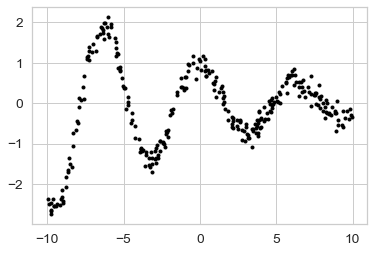

In [16]:
plt.plot(x_NF[:,0], y_N, 'k.');

In [17]:
# Setup for plotting 

W, H = 6, 4   # panel width/height
G = 501       # num grid points to use
x_grid_G1 = np.linspace(-11, 11, G).reshape((G,1))

## Sanity Check: Can JAX's JIT calculate logpdf very fast?

In [18]:
prior_params = {
    'w_mean':0.0, 'b_mean':0.0, 'w_stddev':3.0, 'b_stddev':3.0}
lik_params = {'tau':0.3}

def calc_logpdf_posterior(nn_params):
    return (
        calc_logpdf_prior(nn_params, prior_params)
        + calc_logpdf_likelihood(nn_params, x_NF[:N], y_N[:N], lik_params))
fast_logpdf_posterior = jax.jit(calc_logpdf_posterior)

In [19]:
nn_params = make_nn_params_as_list_of_dicts(1, 1, [16])

fast_logpdf_posterior(nn_params); # burn the first call, later ones will be much faster

In [20]:
%timeit -r7 -n100 calc_logpdf_posterior(nn_params)

5.46 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit -r7 -n100 fast_logpdf_posterior(nn_params)

44.2 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Run RW MCMC to draw Posterior Samples with arch []

In [22]:
arch = []
prior_params = {
    'w_mean':0.0, 'b_mean':0.0, 'w_stddev':3.0, 'b_stddev':3.0}
lik_params = {'tau':0.3}

history_nn_samples = {}
history_logpdf = {}
S = 100
B = 1000

In [23]:
N = 4
for chain in [1, 2, 3, 4]:
    print("Chain %d/4" % chain)
    history_nn_samples[N, chain], history_logpdf[N, chain] = draw_posterior_samples_via_random_walk(
        arch, N=N, x_NF=x_NF, y_N=y_N, n_samples=S, n_samples_burnin=B,
        prior_params=prior_params,
        lik_params=lik_params,
        sigma_RW=0.06,
        print_every=1000,
        random_state=chain)

Chain 1/4
.....      1/  1100 iterations complete, accept rate 0.000 =      0/     1
.....      2/  1100 iterations complete, accept rate 0.500 =      1/     2
.....      3/  1100 iterations complete, accept rate 0.667 =      2/     3
.....   1000/  1100 iterations complete, accept rate 0.464 =    464/  1000
Chain 2/4
.....      1/  1100 iterations complete, accept rate 0.000 =      0/     1
.....      2/  1100 iterations complete, accept rate 0.000 =      0/     2
.....      3/  1100 iterations complete, accept rate 0.000 =      0/     3
.....   1000/  1100 iterations complete, accept rate 0.475 =    475/  1000
Chain 3/4
.....      1/  1100 iterations complete, accept rate 0.000 =      0/     1
.....      2/  1100 iterations complete, accept rate 0.000 =      0/     2
.....      3/  1100 iterations complete, accept rate 0.333 =      1/     3
.....   1000/  1100 iterations complete, accept rate 0.417 =    417/  1000
Chain 4/4
.....      1/  1100 iterations complete, accept rate 0.000 =

In [24]:
N = 20
for chain in [1, 2, 3, 4]:
    print("Chain %d/4" % chain)
    history_nn_samples[N, chain], history_logpdf[N, chain] = draw_posterior_samples_via_random_walk(
        arch, N=N, x_NF=x_NF, y_N=y_N, n_samples=S, n_samples_burnin=B,
        prior_params=prior_params,
        lik_params=lik_params,
        sigma_RW=0.06,
        print_every=1000,
        random_state=chain)

Chain 1/4
.....      1/  1100 iterations complete, accept rate 0.000 =      0/     1
.....      2/  1100 iterations complete, accept rate 0.500 =      1/     2
.....      3/  1100 iterations complete, accept rate 0.333 =      1/     3
.....   1000/  1100 iterations complete, accept rate 0.253 =    253/  1000
Chain 2/4
.....      1/  1100 iterations complete, accept rate 0.000 =      0/     1
.....      2/  1100 iterations complete, accept rate 0.000 =      0/     2
.....      3/  1100 iterations complete, accept rate 0.000 =      0/     3
.....   1000/  1100 iterations complete, accept rate 0.282 =    282/  1000
Chain 3/4
.....      1/  1100 iterations complete, accept rate 0.000 =      0/     1
.....      2/  1100 iterations complete, accept rate 0.000 =      0/     2
.....      3/  1100 iterations complete, accept rate 0.333 =      1/     3
.....   1000/  1100 iterations complete, accept rate 0.229 =    229/  1000
Chain 4/4
.....      1/  1100 iterations complete, accept rate 0.000 =

## Visualize Posterior Samples with arch []

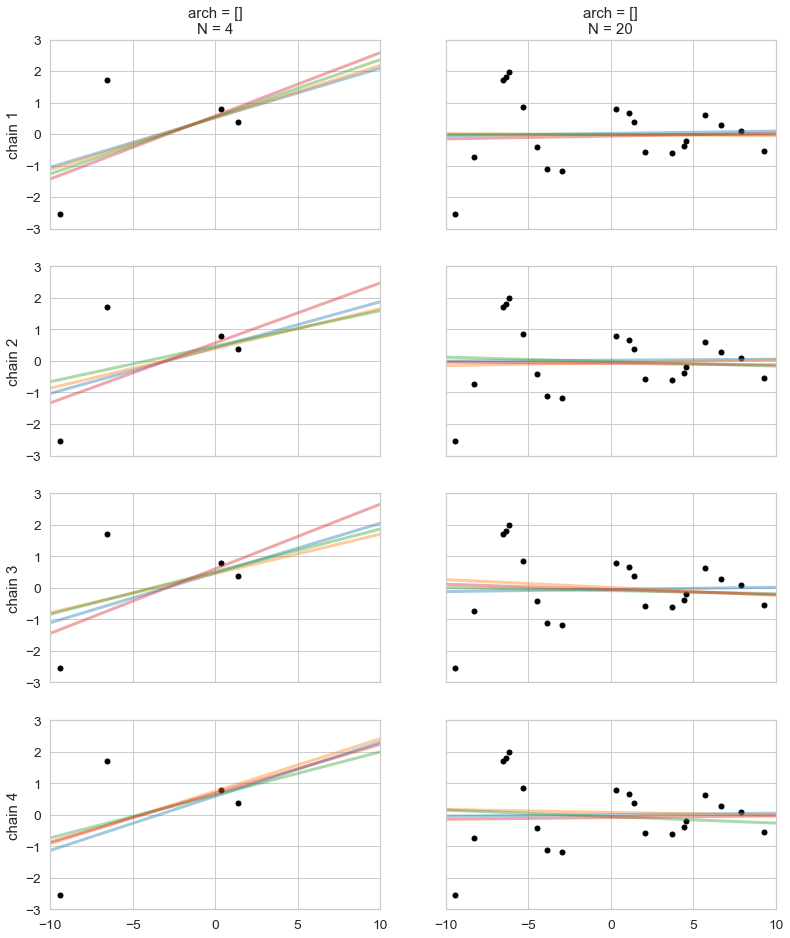

In [25]:
chain_list = [1, 2, 3, 4]
N_list = [4, 20]

ncols = len(N_list)
nrows = len(chain_list)
_, axgrid = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*W+1, nrows*H), sharey=True, sharex=True)

for row_id, chain in enumerate(chain_list):
    for col_id, N in enumerate(N_list):
        ax = axgrid[row_id, col_id]
        ax.plot(x_NF[:N,0], y_N[:N], 'k.', markersize=10)
        S_N = len(history_nn_samples[N, chain])
        for ss in range(S_N)[::S_N//4]:                # show 5 evenly-spaced samples from all "kept" samples
            nn_params = history_nn_samples[N, chain][ss]
            ax.plot(
                x_grid_G1[:,0],
                predict_f_given_x_via_NN(x_grid_G1, nn_params),
                '-', linewidth=3, alpha=0.4)
        if col_id == 0:
            ax.set_ylabel("chain %d" % chain)
        if row_id == 0:
            ax.set_title("arch = %s\nN = %d" % (str(arch), N))
plt.xlim([-10, 10]);
plt.ylim([-3, 3]);

### Diagnostic plot: posterior logpdf over samples, across chains

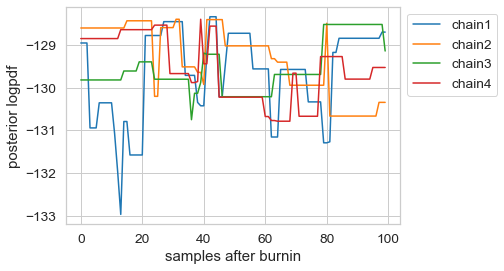

In [26]:
for chain in chain_list:
    plt.plot(history_logpdf[N, chain], label='chain%d' % chain);
plt.legend(bbox_to_anchor=(1.0, 1.0));
plt.xlabel('samples after burnin');
plt.ylabel('posterior logpdf');

### Concept check: have any of your chains converged to the intended posterior?

### Concept check: what other diagnostic plots would you want to make?

## Run RW MCMC to draw Posterior Samples with arch [16]

In [27]:
arch = [16]
prior_params = {
    'w_mean':0.0, 'b_mean':0.0, 'w_stddev':3.0, 'b_stddev':3.0}
lik_params = {'tau':0.3}

history_nn_samples = {} # Will be addressed by (N, chain_id) tuples
history_logpdf = {}
S = 1001
B = 5000

In [28]:
N = 4
for chain in [1, 2, 3, 4]:
    print("Chain %d/4" % chain)
    history_nn_samples[N, chain], history_logpdf[N, chain] = draw_posterior_samples_via_random_walk(
        arch, N=N, x_NF=x_NF, y_N=y_N, n_samples=S, n_samples_burnin=B,
        prior_params=prior_params,
        lik_params=lik_params,
        sigma_RW=0.06,
        print_every=1000,
        random_state=chain)

Chain 1/4
.....      1/  6001 iterations complete, accept rate 0.000 =      0/     1
.....      2/  6001 iterations complete, accept rate 0.000 =      0/     2
.....      3/  6001 iterations complete, accept rate 0.000 =      0/     3
.....   1000/  6001 iterations complete, accept rate 0.238 =    238/  1000
.....   2000/  6001 iterations complete, accept rate 0.173 =    346/  2000
.....   3000/  6001 iterations complete, accept rate 0.153 =    460/  3000
.....   4000/  6001 iterations complete, accept rate 0.141 =    566/  4000
.....   5000/  6001 iterations complete, accept rate 0.129 =    644/  5000
.....   6000/  6001 iterations complete, accept rate 0.118 =    711/  6000
Chain 2/4
.....      1/  6001 iterations complete, accept rate 0.000 =      0/     1
.....      2/  6001 iterations complete, accept rate 0.000 =      0/     2
.....      3/  6001 iterations complete, accept rate 0.000 =      0/     3
.....   1000/  6001 iterations complete, accept rate 0.130 =    130/  1000
.....

In [29]:
N = 20
for chain in [1, 2, 3, 4]:
    print("Chain %d/4" % chain)
    history_nn_samples[N, chain], history_logpdf[N, chain] = draw_posterior_samples_via_random_walk(
        arch, N=N, x_NF=x_NF, y_N=y_N, n_samples=S, n_samples_burnin=B,
        prior_params=prior_params,
        lik_params=lik_params,
        sigma_RW=0.06,
        print_every=1000,
        random_state=chain)

Chain 1/4
.....      1/  6001 iterations complete, accept rate 0.000 =      0/     1
.....      2/  6001 iterations complete, accept rate 0.000 =      0/     2
.....      3/  6001 iterations complete, accept rate 0.000 =      0/     3
.....   1000/  6001 iterations complete, accept rate 0.192 =    192/  1000
.....   2000/  6001 iterations complete, accept rate 0.126 =    251/  2000
.....   3000/  6001 iterations complete, accept rate 0.102 =    306/  3000
.....   4000/  6001 iterations complete, accept rate 0.095 =    380/  4000
.....   5000/  6001 iterations complete, accept rate 0.093 =    463/  5000
.....   6000/  6001 iterations complete, accept rate 0.096 =    574/  6000
Chain 2/4
.....      1/  6001 iterations complete, accept rate 0.000 =      0/     1
.....      2/  6001 iterations complete, accept rate 0.000 =      0/     2
.....      3/  6001 iterations complete, accept rate 0.000 =      0/     3
.....   1000/  6001 iterations complete, accept rate 0.078 =     78/  1000
.....

## Visualize posterior samples from arch [16]

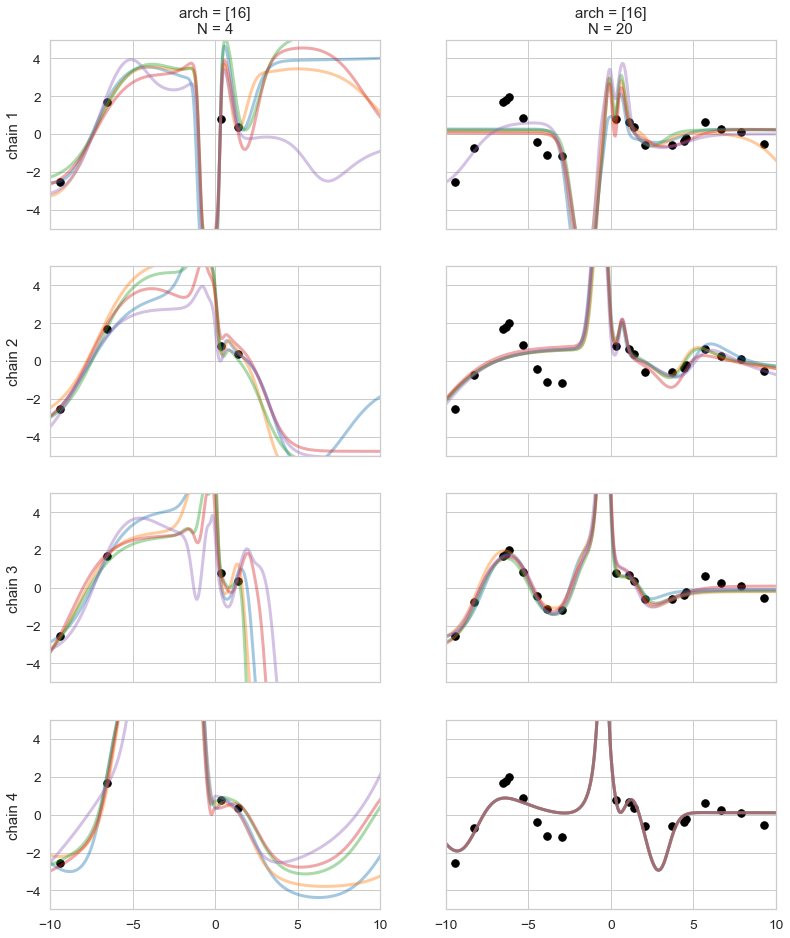

In [30]:
chain_list = [1, 2, 3, 4]
N_list = [4, 20]

ncols = len(N_list)
nrows = len(chain_list)
_, axgrid = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*W+1, nrows*H), sharey=True, sharex=True)

for row_id, chain in enumerate(chain_list):
    for col_id, N in enumerate(N_list):
        ax = axgrid[row_id, col_id]
        ax.plot(x_NF[:N,0], y_N[:N], 'k.', markersize=15)
        S_N = len(history_nn_samples[N, chain])
        for ss in range(S_N)[::S_N//4]:                # show 5 evenly-spaced samples from all "kept" samples
            nn_params = history_nn_samples[N, chain][ss]
            ax.plot(
                x_grid_G1[:,0],
                predict_f_given_x_via_NN(x_grid_G1, nn_params),
                '-', linewidth=3, alpha=0.4)
        if col_id == 0:
            ax.set_ylabel("chain %d" % chain)
        if row_id == 0:
            ax.set_title("arch = %s\nN = %d" % (str(arch), N))
plt.xlim([-10, 10]);
plt.ylim([-5, 5]);

### Diagnostic plot: posterior logpdf over samples, across chains

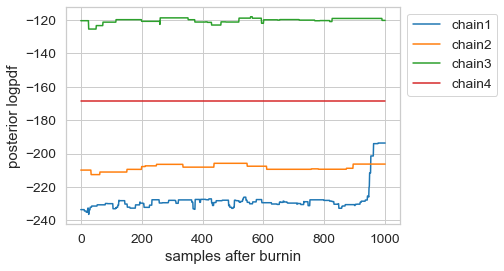

In [31]:
for chain in chain_list:
    plt.plot(history_logpdf[N, chain], label='chain%d' % chain);
plt.legend(bbox_to_anchor=(1.0, 1.0));
plt.xlabel('samples after burnin');
plt.ylabel('posterior logpdf');

## Concept check: have any of your chains converged to the intended posterior?

TODO student answer here

# Part 5: Towards Hamiltonian Monte Carlo

Why is it so hard to sample with a random walk?

The proposal is dumb! It just adds random noise to the current parameters. Very unlikely to succeed, especially in high dimensions.

What we need instead is a way of generating proposed configurations that is informed by the local geometry of the posterior, so that ideally,

* if we aren't yet at the typical set, we'll move rapidly to get there
* if we are at the typical set, we'll explore it thoroughly

Hamiltonian Monte Carlo allows us a route to do just that

* [Fig 10](https://arxiv.org/pdf/1701.02434.pdf#page=17) : Intuition that RW is slow to explore
* [Fig 11](https://arxiv.org/pdf/1701.02434.pdf#page=18) : Ideal behavior of MCMC
* [Fig 12](https://arxiv.org/pdf/1701.02434.pdf#page=19) : A carefully-designed vector field can yield ideal behavior
* [Fig 13](https://arxiv.org/pdf/1701.02434.pdf#page=20) : The gradient of the log posterior isn't the right vector field
* [Fig 17]() : Analogy time! A physical satellite (current state of sampler) orbiting a planet (mode of distribution) can have desired vector field when **momentum** is introduced

HMC is essentially two key modifications away from the random walk sampler:

* We've added an *auxiliary random variable*, "momentum", with same size as original "location" variable
* We adjust the proposal from a random walk in location space to one that (1) proposes a random momentum value, then (2) deterministically glides along a trajectory in phase space that preserves overall energy